In [138]:
import pandas as pd
import numpy as np 
import pylab 
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

<h1>Merge the 2 datasets of people who were killed and not killed

In [139]:
df_killed = pd.read_csv('cleaned_dataset_killed_for_ML.csv')

In [140]:
df_not_killed = pd.read_csv('cleaned_dataset_not_killed.csv')

In [141]:
df_killed.columns


Index(['age', 'race', 'date', 'state', 'police_agency', 'description of death',
       'was armed', 'weapon on victim', 'geography type', 'male',
       'shooting_involved', 'taser_involved', 'physical_violence_involved',
       'justified', 'armed_with_gun', 'armed_with_knife', 'was_a_threat',
       'was_fleeing', 'mental_illness', 'home_involved', 'vehicle_involved'],
      dtype='object')

In [142]:
len(df_killed)

7698

In [143]:
df_not_killed.columns


Index(['state', 'police_agency', 'age', 'race', 'killed', 'weapon on victim',
       'description of event', 'justified', 'male', 'armed_with_gun',
       'armed_with_knife', 'vehicle_involved', 'home_involved', 'was_fleeing',
       'shooting_involved', 'taser_involved', 'physical_violence_involved'],
      dtype='object')

In [144]:
len(df_not_killed)

573

<h3>add new col, 'killed', into df_killed

In [145]:
df_killed['killed'] = 1

<h3>merge the 2 datasets

In [146]:
df = pd.concat([df_killed, df_not_killed], axis = 'rows')

In [147]:
df.columns

Index(['age', 'race', 'date', 'state', 'police_agency', 'description of death',
       'was armed', 'weapon on victim', 'geography type', 'male',
       'shooting_involved', 'taser_involved', 'physical_violence_involved',
       'justified', 'armed_with_gun', 'armed_with_knife', 'was_a_threat',
       'was_fleeing', 'mental_illness', 'home_involved', 'vehicle_involved',
       'killed', 'description of event'],
      dtype='object')

In [148]:
df.reset_index(inplace=True)

In [149]:
df.drop('index', axis = 'columns', inplace = True)

<h1>add state-level features

From making visualisations of the correlation between number of police killings and:
1) Average income level of a state
2) Average education level of a state
3) Average share of whites, average share of blacks of a state

We found that there is a relationship in all 3 cases. So we add each of the 3 factors into our model

In [150]:
income_data = pd.read_csv("MedianHouseholdIncome2015.csv", encoding = "ISO-8859-1")
income_data['Median Income'] = pd.to_numeric(income_data['Median Income'],errors='coerce')
avgincome = pd.DataFrame({'income' : income_data.groupby(['Geographic Area'])['Median Income'].mean()}).reset_index()


In [151]:
race_data = pd.read_csv("ShareRaceByCity.csv", encoding = "ISO-8859-1")
race_data['share_white'] = pd.to_numeric(race_data['share_white'],errors='coerce')
race_data['share_black'] = pd.to_numeric(race_data['share_black'],errors='coerce')

avgwhite = pd.DataFrame({'avgwhite' : race_data.groupby(['Geographic area'])['share_white'].mean()}).reset_index()
avgblack = pd.DataFrame({'avgblack' : race_data.groupby(['Geographic area'])['share_black'].mean()}).reset_index()


In [152]:
education_data = pd.read_csv("PercentOver25CompletedHighSchool.csv", encoding = "ISO-8859-1")
education_data['percent_completed_hs'] = pd.to_numeric(education_data['percent_completed_hs'],errors='coerce')
avgedu = pd.DataFrame({'avgedu' : education_data.groupby(['Geographic Area'])['percent_completed_hs'].mean()}).reset_index()


In [153]:
def applyincome(state):
    for i in range(avgincome['Geographic Area'].size):
        if avgincome['Geographic Area'].iloc[i] == state:
            return avgincome['income'].iloc[i]

In [154]:
def applyavgedu(state):
    for i in range(avgedu['Geographic Area'].size):
        if avgedu['Geographic Area'].iloc[i] == state:
            return avgedu['avgedu'].iloc[i]

In [155]:
def applyavgwhite(state):
    for i in range(avgwhite['Geographic area'].size):
        if avgwhite['Geographic area'].iloc[i] == state:
            return avgwhite['avgwhite'].iloc[i]

In [156]:
df['state_log_income'] = np.log(df['state'].apply(applyincome))  #we log median household income to scale the income figures down, so that they can be around the same scale as the other continuous variables in our dataset
df['state_white_share'] = df['state'].apply(applyavgwhite)
df['state_education_level'] = df['state'].apply(applyavgedu)

In [157]:
df.drop('state', axis = 'columns', inplace = True)  #remove state else multicollinearity

<h1>encode categorical variables

<h3>1) do target encoding on 'agency' col</h3>
<br>https://maxhalford.github.io/blog/target-encoding/

In [158]:
from category_encoders import TargetEncoder

In [159]:
encoder = TargetEncoder()
df['police_agency_encoded'] = encoder.fit_transform(df['police_agency'], df['killed'])

In [160]:
df.drop('police_agency', axis = 'columns', inplace = True)

<h3>2) do one hot encoding on 'geography_type' col



In [161]:
geography_type_dummies = pd.get_dummies(df['geography type'], prefix='geography_type')
geography_type_dummies


,geography_type_Rural,geography_type_Suburban,geography_type_Urban
0,0,0,0
1,0,0,0
2,1,0,0
3,0,0,1
4,0,1,0
...,...,...,...
8266,0,0,0
8267,0,0,0
8268,0,0,0
8269,0,0,0


In [162]:
df = pd.concat([df, geography_type_dummies], axis=1)

In [163]:
for ind in df.index:
    row = df.loc[ind]
    if row['geography_type_Rural'] == 0 and row['geography_type_Suburban'] == 0 and row['geography_type_Urban'] == 0:
        df.loc[ind, 'geography_type_Rural'] = np.nan
        df.loc[ind, 'geography_type_Suburban'] = np.nan
        df.loc[ind, 'geography_type_Urban'] = np.nan
    
    

In [164]:
df.drop('geography type', axis = 'columns', inplace = True)

<h3>3) do one hot encoding on 'race' col

In [165]:
race_dummies = pd.get_dummies(df['race'], prefix='race')


In [166]:
df = pd.concat([df, race_dummies], axis=1)

In [167]:
df.columns

Index(['age', 'race', 'date', 'description of death', 'was armed',
       'weapon on victim', 'male', 'shooting_involved', 'taser_involved',
       'physical_violence_involved', 'justified', 'armed_with_gun',
       'armed_with_knife', 'was_a_threat', 'was_fleeing', 'mental_illness',
       'home_involved', 'vehicle_involved', 'killed', 'description of event',
       'state_log_income', 'state_white_share', 'state_education_level',
       'police_agency_encoded', 'geography_type_Rural',
       'geography_type_Suburban', 'geography_type_Urban', 'race_Asian',
       'race_Black', 'race_Hispanic', 'race_Native American', 'race_White'],
      dtype='object')

In [168]:
for ind in df.index:
    row = df.loc[ind]
    if row['race_Asian'] == 0 and row['race_Black'] == 0 and row['race_Hispanic'] == 0 and row['race_Native American'] == 0 and row['race_White'] == 0:
        df.loc[ind, 'race_Asian'] = np.nan
        df.loc[ind, 'race_Black'] = np.nan
        df.loc[ind, 'race_Hispanic'] = np.nan
        df.loc[ind, 'race_Native American'] = np.nan
        df.loc[ind, 'race_White'] = np.nan
    

In [169]:
df.drop('race', axis = 'columns', inplace = True)

<h1>subset df to only the cols we are using in our model


In [170]:
df = df.drop(['date', 'description of death', 'was armed', 'weapon on victim', 'description of event'], axis = 'columns')


In [171]:
df.columns

Index(['age', 'male', 'shooting_involved', 'taser_involved',
       'physical_violence_involved', 'justified', 'armed_with_gun',
       'armed_with_knife', 'was_a_threat', 'was_fleeing', 'mental_illness',
       'home_involved', 'vehicle_involved', 'killed', 'state_log_income',
       'state_white_share', 'state_education_level', 'police_agency_encoded',
       'geography_type_Rural', 'geography_type_Suburban',
       'geography_type_Urban', 'race_Asian', 'race_Black', 'race_Hispanic',
       'race_Native American', 'race_White'],
      dtype='object')

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8271 entries, 0 to 8270
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         8021 non-null   float64
 1   male                        8244 non-null   float64
 2   shooting_involved           8252 non-null   float64
 3   taser_involved              8250 non-null   float64
 4   physical_violence_involved  8250 non-null   float64
 5   justified                   1976 non-null   float64
 6   armed_with_gun              8271 non-null   float64
 7   armed_with_knife            8271 non-null   float64
 8   was_a_threat                5568 non-null   float64
 9   was_fleeing                 5772 non-null   float64
 10  mental_illness              6322 non-null   float64
 11  home_involved               8250 non-null   float64
 12  vehicle_involved            8271 non-null   float64
 13  killed                      8271 

In [173]:
len(df)

8271

<h1>impute missing values using KNN imputation

In [174]:
from sklearn.impute import KNNImputer

In [175]:
imputer = KNNImputer(n_neighbors=5)

In [176]:
array = imputer.fit_transform(df)

In [177]:
df = pd.DataFrame(array, columns=df.columns)

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8271 entries, 0 to 8270
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         8271 non-null   float64
 1   male                        8271 non-null   float64
 2   shooting_involved           8271 non-null   float64
 3   taser_involved              8271 non-null   float64
 4   physical_violence_involved  8271 non-null   float64
 5   justified                   8271 non-null   float64
 6   armed_with_gun              8271 non-null   float64
 7   armed_with_knife            8271 non-null   float64
 8   was_a_threat                8271 non-null   float64
 9   was_fleeing                 8271 non-null   float64
 10  mental_illness              8271 non-null   float64
 11  home_involved               8271 non-null   float64
 12  vehicle_involved            8271 non-null   float64
 13  killed                      8271 

<h1>split into training and testing data

In [179]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.3)

<h1>handle class imbalance in 'killed' (too little killed=0): upsample minority class</h1>

In [180]:
from sklearn.utils import resample

In [181]:
train_majority = train[train.killed==1]
train_minority = train[train.killed==0]
 
# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(train_majority),    # to match majority class
                                 random_state=15) # reproducible results
 
train = pd.concat([train_majority, train_minority_upsampled])
 

In [182]:
# new class counts: check they are the same
train.killed.value_counts()

0.0    5388
1.0    5388
Name: killed, dtype: int64

<h1>create X and y vars

In [183]:
X_train = train.drop('killed', axis = 'columns')
y_train = train['killed']
X_test = test.drop('killed', axis = 'columns')
y_test = test['killed']

<h1>normalize features</h1>

In [184]:
X_train.describe()

,age,male,shooting_involved,taser_involved,physical_violence_involved,justified,armed_with_gun,armed_with_knife,was_a_threat,was_fleeing,...,state_education_level,police_agency_encoded,geography_type_Rural,geography_type_Suburban,geography_type_Urban,race_Asian,race_Black,race_Hispanic,race_Native American,race_White
count,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,...,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000
mean,34.023051,0.951670,0.975835,0.051151,0.005011,0.741518,0.510301,0.112658,0.634577,0.309261,...,84.669694,0.848956,0.207313,0.499536,0.293151,0.021863,0.322476,0.193189,0.018671,0.443801
std,13.256217,0.213639,0.152987,0.219606,0.070615,0.344468,0.499917,0.316189,0.350215,0.426791,...,4.482203,0.254114,0.331732,0.393949,0.364867,0.132892,0.425419,0.360811,0.119583,0.451165
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,75.690000,0.002301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,1.000000,1.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.400000,0.000000,...,81.955430,0.930722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,31.200000,1.000000,1.000000,0.000000,0.000000,0.800000,1.000000,0.000000,0.800000,0.000000,...,84.880270,0.930722,0.000000,0.600000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000
75%,41.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.800000,...,88.422481,0.981368,0.200000,1.000000,0.600000,0.000000,0.800000,0.200000,0.000000,1.000000
max,199.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,92.404082,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [185]:
X_test.describe()

,age,male,shooting_involved,taser_involved,physical_violence_involved,justified,armed_with_gun,armed_with_knife,was_a_threat,was_fleeing,...,state_education_level,police_agency_encoded,geography_type_Rural,geography_type_Suburban,geography_type_Urban,race_Asian,race_Black,race_Hispanic,race_Native American,race_White
count,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,...,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000
mean,35.850282,0.945125,0.959307,0.051652,0.009670,0.791459,0.531426,0.137792,0.658743,0.334972,...,84.035790,0.947056,0.211523,0.510234,0.278243,0.017566,0.300242,0.197583,0.017647,0.466962
std,12.825497,0.227002,0.197618,0.221222,0.097877,0.256082,0.499112,0.344751,0.412948,0.416248,...,4.582027,0.116622,0.398481,0.485036,0.435860,0.129542,0.452936,0.394064,0.130338,0.492962
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,75.690000,0.002301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,1.000000,1.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.200000,0.000000,...,80.849873,0.930722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,1.000000,1.000000,0.000000,0.000000,0.800000,1.000000,0.000000,1.000000,0.000000,...,82.909743,0.981368,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,44.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.800000,...,88.344600,0.999829,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,92.404082,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [186]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data. use this to transform testing data too
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train = pd.DataFrame(norm.transform(X_train), columns=X_train.columns)

# transform testing data
X_test = pd.DataFrame(norm.transform(X_test), columns=X_test.columns)

It is a good practice to fit the scaler on the training data and then use it to transform the testing data. This would avoid any data leakage during the model testing process

In [187]:
X_train.describe()  #check the normalisation worked

,age,male,shooting_involved,taser_involved,physical_violence_involved,justified,armed_with_gun,armed_with_knife,was_a_threat,was_fleeing,...,state_education_level,police_agency_encoded,geography_type_Rural,geography_type_Suburban,geography_type_Urban,race_Asian,race_Black,race_Hispanic,race_Native American,race_White
count,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,...,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000,10776.000000
mean,0.166783,0.951670,0.975835,0.051151,0.005011,0.741518,0.510301,0.112658,0.634577,0.309261,...,0.537253,0.848607,0.207313,0.499536,0.293151,0.021863,0.322476,0.193189,0.018671,0.443801
std,0.066951,0.213639,0.152987,0.219606,0.070615,0.344468,0.499917,0.316189,0.350215,0.426791,...,0.268169,0.254701,0.331732,0.393949,0.364867,0.132892,0.425419,0.360811,0.119583,0.451165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.121212,1.000000,1.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.400000,0.000000,...,0.374859,0.930562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.152525,1.000000,1.000000,0.000000,0.000000,0.800000,1.000000,0.000000,0.800000,0.000000,...,0.549852,0.930562,0.000000,0.600000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000
75%,0.202020,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.800000,...,0.761782,0.981325,0.200000,1.000000,0.600000,0.000000,0.800000,0.200000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [188]:
X_test.describe()  #check the normalisation worked

,age,male,shooting_involved,taser_involved,physical_violence_involved,justified,armed_with_gun,armed_with_knife,was_a_threat,was_fleeing,...,state_education_level,police_agency_encoded,geography_type_Rural,geography_type_Suburban,geography_type_Urban,race_Asian,race_Black,race_Hispanic,race_Native American,race_White
count,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,...,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000,2482.000000
mean,0.176012,0.945125,0.959307,0.051652,0.009670,0.791459,0.531426,0.137792,0.658743,0.334972,...,0.499327,0.946934,0.211523,0.510234,0.278243,0.017566,0.300242,0.197583,0.017647,0.466962
std,0.064775,0.227002,0.197618,0.221222,0.097877,0.256082,0.499112,0.344751,0.412948,0.416248,...,0.274142,0.116891,0.398481,0.485036,0.435860,0.129542,0.452936,0.394064,0.130338,0.492962
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.126263,1.000000,1.000000,0.000000,0.000000,0.600000,0.000000,0.000000,0.200000,0.000000,...,0.308714,0.930562,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.166667,1.000000,1.000000,0.000000,0.000000,0.800000,1.000000,0.000000,1.000000,0.000000,...,0.431956,0.981325,0.000000,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.217172,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.800000,...,0.757122,0.999828,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,0.474747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<h1>1) Logistic Regression Model</h1>

<h3>Remove multicollinearity</h3>
<br>Logistic regression assumes that the predictor variables (features) are not correlated with one another. Check their pairwise correlation and from the analysis, remove those variables which are highly correlated.

In [189]:
df.corr()

,age,male,shooting_involved,taser_involved,physical_violence_involved,justified,armed_with_gun,armed_with_knife,was_a_threat,was_fleeing,...,state_education_level,police_agency_encoded,geography_type_Rural,geography_type_Suburban,geography_type_Urban,race_Asian,race_Black,race_Hispanic,race_Native American,race_White
age,1.000000,-0.018346,-0.017620,0.016125,0.017115,0.043948,0.068118,0.025700,0.039906,-0.195269,...,0.002062,0.054643,0.126206,-0.019450,-0.095057,-0.003421,-0.189372,-0.108565,-0.035991,0.268458
male,-0.018346,1.000000,-0.008871,0.016430,0.017451,0.106412,0.077389,-0.015764,0.046516,0.027431,...,0.031061,0.005263,0.003489,-0.025617,0.025294,-0.005495,0.047393,0.031625,-0.001388,-0.066039
shooting_involved,-0.017620,-0.008871,1.000000,-0.547741,-0.458033,0.054847,0.205629,0.057585,0.074370,0.028229,...,-0.000606,-0.025722,0.008318,-0.007971,0.001182,0.001519,-0.036880,-0.007509,0.010874,0.035781
taser_involved,0.016125,0.016430,-0.547741,1.000000,0.001424,-0.034482,-0.222796,0.085405,-0.082498,-0.056712,...,0.003641,0.008696,-0.028113,0.014000,0.010411,-0.011098,0.019856,0.009060,-0.001499,-0.021783
physical_violence_involved,0.017115,0.017451,-0.458033,0.001424,1.000000,-0.044851,-0.099794,-0.030984,-0.055126,-0.014223,...,-0.000843,0.007340,-0.029300,0.012415,0.013273,0.025331,0.012834,0.009522,0.003056,-0.026674
justified,0.043948,0.106412,0.054847,-0.034482,-0.044851,1.000000,0.214588,-0.014237,0.109863,0.036138,...,0.089017,0.067590,0.039725,-0.000450,-0.036235,0.002630,-0.133657,0.017798,0.016087,0.101596
armed_with_gun,0.068118,0.077389,0.205629,-0.222796,-0.099794,0.214588,1.000000,-0.399831,0.362260,0.018333,...,-0.011128,0.007895,0.050777,-0.033812,-0.009312,-0.010357,0.011116,-0.068970,-0.031534,0.056234
armed_with_knife,0.025700,-0.015764,0.057585,0.085405,-0.030984,-0.014237,-0.399831,1.000000,-0.181363,-0.144830,...,0.040622,0.025361,-0.047119,0.028552,0.011786,0.056186,-0.057133,0.040501,0.036368,-0.005523
was_a_threat,0.039906,0.046516,0.074370,-0.082498,-0.055126,0.109863,0.362260,-0.181363,1.000000,0.002694,...,-0.041462,-0.007986,0.021985,-0.009123,-0.010174,-0.007417,0.022528,-0.067214,-0.023698,0.041486
was_fleeing,-0.195269,0.027431,0.028229,-0.056712,-0.014223,0.036138,0.018333,-0.144830,0.002694,1.000000,...,0.001759,0.007154,-0.004658,-0.039891,0.048720,-0.025767,0.073632,0.036908,0.012640,-0.092684


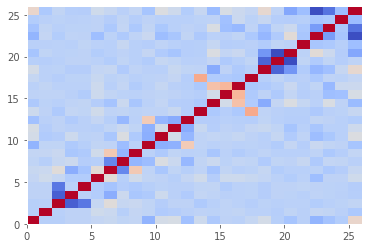

In [190]:
import matplotlib.pyplot as plt
plt.pcolor(df.corr(),cmap='coolwarm')  #use other color maps: https://matplotlib.org/examples/color/colormaps_reference.html


<h2>Fit model

In [191]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=2000)

#train log reg model on training df
model.fit(X_train, y_train)

#use trained model on testing df to predict y var
y_pred = model.predict(X_test)

<h2>assess model performance

<h3>confusion matrix

In [192]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)

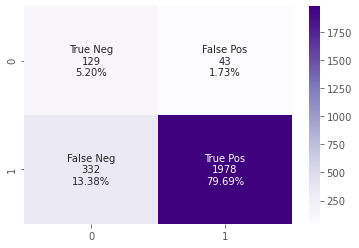

In [193]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples')


<h3>calculate all metrics

In [194]:
def c_m_analysis(cf_matrix):
    tn, fp, fn, tp = cf_matrix.ravel()

    recall_tpr = tp/(tp+fn)
    specificity_tnr = tn/(tn+fp)
    precision = tp/(tp+fp)
    fpr = fp/(fp+tn)
    f_score = 2*precision*recall_tpr/(precision+recall_tpr)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    print(f'Recall/TPR:\t\t{recall_tpr*100:.2f}% of individuals killed identified')
    print(f'Specificity/TNR:\t{specificity_tnr*100:.2f}% of individuals not killed identified')
    print(f'Precision:\t\t{precision*100:.2f}% of individuals identified to be killed are actually killed')
    print(f'False Positive Rate:\t{fpr*100:.2f}% of individuals not killed identified to be killed')
    print(f'f-score:\t\t{f_score*100:.2f}% weighted average between precision and recall')
    print(f'Accuracy:\t\t{accuracy*100:.2f}% of individuals correctly classified')


In [195]:
c_m_analysis(cf_matrix)


Recall/TPR:		85.63% of individuals killed identified
Specificity/TNR:	75.00% of individuals not killed identified
Precision:		97.87% of individuals identified to be killed are actually killed
False Positive Rate:	25.00% of individuals not killed identified to be killed
f-score:		91.34% weighted average between precision and recall
Accuracy:		84.89% of individuals correctly classified


<h3>the metric our project cares about</h3>
<li>recall/ TPR: we want to identify killings to be able to prevent them
<li>precision: we want to be sure when we identify people as going to be killed
<br>so, we look at f-score to decide between models, which is a combined metric of precision and recall
    
    

<h3>ROC curve

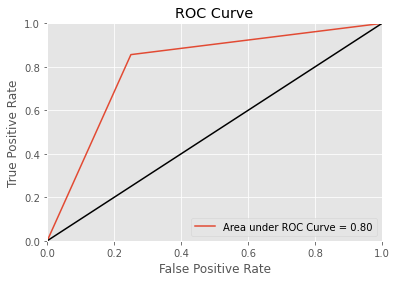

In [196]:
from sklearn.metrics import roc_curve, auc

(fpr, tpr, thresholds) = roc_curve(y_test, y_pred)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Area under ROC Curve = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

<h3>precision-recall curve</h3>
<br><b>more useful in the context of our project than ROC curve bc we are not interested in the skill of the model in identifying '0'!

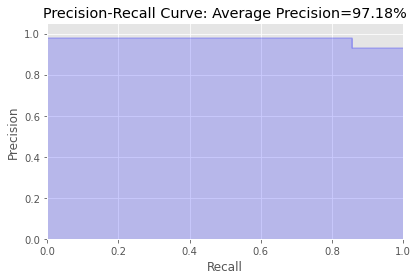

In [197]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

step_kwargs = ({'step' : 'post'})

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve: Average Precision={average_precision*100:.2f}%')
plt.tight_layout()

<h1>2) Random Forest Model</h1>

<h2>Fit model

<H3>randomsearchCV

In [198]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [199]:
rf = RandomForestClassifier()

rf_random_search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=15, n_jobs = -1)

rf_random_search.fit(X_train, np.ravel(y_train))


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=15, verbose=2)

In [200]:
rf_random_search.best_params_


{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [201]:
rf_random_search.best_score_  #increased from base model

0.9988864142538976

In [202]:
random_search_optimal_model = RandomForestClassifier(n_estimators= 1400,min_samples_split= 5,min_samples_leaf= 1,max_features= 'auto',max_depth= 40,bootstrap= False)
random_search_optimal_model.fit(X_train, np.ravel(y_train))


RandomForestClassifier(bootstrap=False, max_depth=40, min_samples_split=5,
                       n_estimators=1400)

In [203]:
y_pred = random_search_optimal_model.predict(X_test)

In [204]:
cf_matrix = confusion_matrix(y_test, y_pred)

In [205]:
c_m_analysis(cf_matrix)

Recall/TPR:		99.74% of individuals killed identified
Specificity/TNR:	93.02% of individuals not killed identified
Precision:		99.48% of individuals identified to be killed are actually killed
False Positive Rate:	6.98% of individuals not killed identified to be killed
f-score:		99.61% weighted average between precision and recall
Accuracy:		99.27% of individuals correctly classified


<H3>gridsearchCV

In [206]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [30, 40, 50],
    'max_features': [2, 3],
    'min_samples_leaf': [0, 1, 2],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [1200, 1400, 1600]
}

rf_grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [207]:
rf_grid_search.fit(X_train, np.ravel(y_train))

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 19.5min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [30, 40, 50],
                         'max_features': [2, 3], 'min_samples_leaf': [0, 1, 2],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [1200, 1400, 1600]},
             verbose=2)

In [208]:
rf_grid_search.best_params_


{'bootstrap': False,
 'max_depth': 30,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1600}

In [209]:
rf_grid_search.best_score_ #further increase in accuracy

0.9994432071269488

In [210]:
optimal_model = RandomForestClassifier(bootstrap=False, max_depth=20, max_features=2, min_samples_leaf=1, min_samples_split=3, n_estimators=1200)


In [211]:
optimal_model.fit(X_train, np.ravel(y_train))

RandomForestClassifier(bootstrap=False, max_depth=20, max_features=2,
                       min_samples_split=3, n_estimators=1200)

In [212]:
y_pred = optimal_model.predict(X_test)

<h2>assess model performance

<h3>confusion matrix

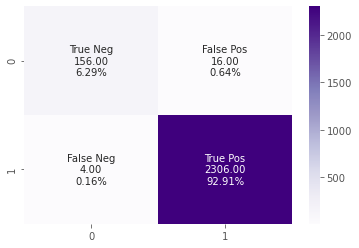

In [213]:
cf_matrix = confusion_matrix(y_test, y_pred)

import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.2f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples')


<h3>calculate all metrics

In [214]:
c_m_analysis(cf_matrix)

Recall/TPR:		99.83% of individuals killed identified
Specificity/TNR:	90.70% of individuals not killed identified
Precision:		99.31% of individuals identified to be killed are actually killed
False Positive Rate:	9.30% of individuals not killed identified to be killed
f-score:		99.57% weighted average between precision and recall
Accuracy:		99.19% of individuals correctly classified


<h3>comparing using only the metrics we care about: precision, recall, f-score

<h3>ROC curve

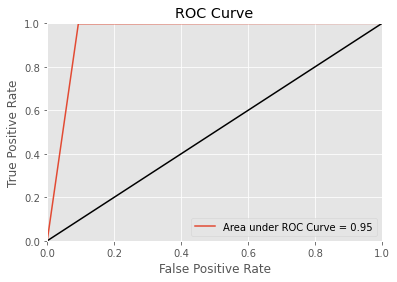

In [215]:
from sklearn.metrics import roc_curve, auc

(fpr, tpr, thresholds) = roc_curve(y_test, y_pred)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Area under ROC Curve = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

<h3>precision-recall curve</h3>
<br><b>more useful in the context of our project than ROC curve bc we are not interested in the skill of the model in identifying '0'!

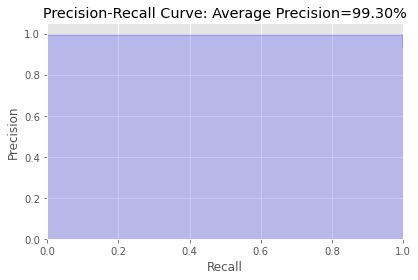

In [216]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

step_kwargs = ({'step' : 'post'})

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve: Average Precision={average_precision*100:.2f}%')
plt.tight_layout()

<h3>feature importance plot

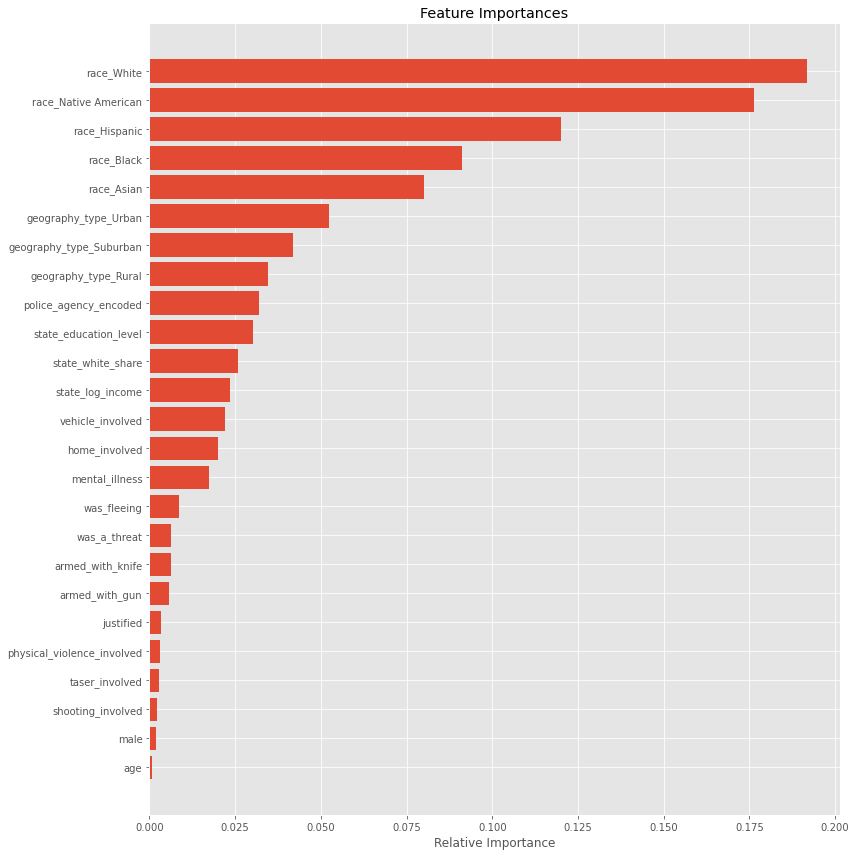

In [217]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = optimal_model.feature_importances_
indices = np.argsort(importances)
feature_names = [key for key in df if not key == 'killed']

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), feature_names)
plt.xlabel('Relative Importance')
plt.tight_layout()


<h1>3) Neural Network Model</h1>

<h2>Fit model

In [218]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100,), max_iter = 500, random_state=1)


we choose a non-linear activation function bc:
<li>the rs between our X and Y is non-linear (can we draw a graph to show this?)
<li>allow the model to create complex mappings between the network’s inputs and outputs, which are essential for learning and modeling complex data which are non-linear or have high dimensionality


In [219]:
model.fit(X_train, y_train)

MLPClassifier(alpha=1e-05, max_iter=500, random_state=1)

In [220]:
y_pred = model.predict(X_test)

<h2>assess model performance

<h3>confusion matrix

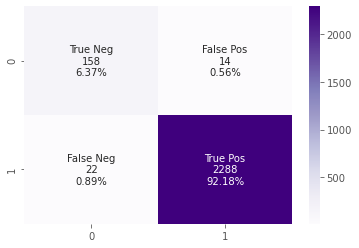

In [221]:
cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Purples')



<h3>calculate all metrics

In [222]:
c_m_analysis(cf_matrix)

Recall/TPR:		99.05% of individuals killed identified
Specificity/TNR:	91.86% of individuals not killed identified
Precision:		99.39% of individuals identified to be killed are actually killed
False Positive Rate:	8.14% of individuals not killed identified to be killed
f-score:		99.22% weighted average between precision and recall
Accuracy:		98.55% of individuals correctly classified


<h3>ROC curve

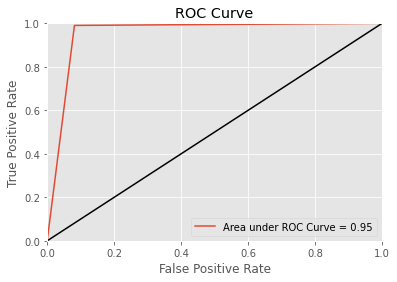

In [223]:
from sklearn.metrics import roc_curve, auc

(fpr, tpr, thresholds) = roc_curve(y_test, y_pred)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Area under ROC Curve = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")


<h3>precision-recall curve</h3>
<br><b>more useful in the context of our project than ROC curve bc we are not interested in the skill of the model in identifying '0'!



Text(0.5, 1.0, 'Precision-Recall Curve: Average Precision=99.33%')

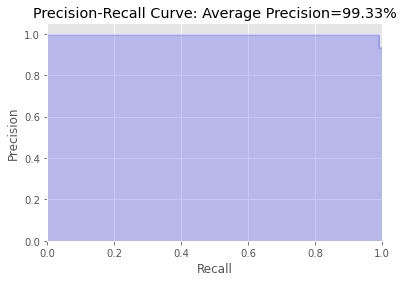

In [224]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)

step_kwargs = ({'step' : 'post'})

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve: Average Precision={average_precision*100:.2f}%')
